In [93]:
set.seed(123)
###define a function to draw samples from a Dirichlet distribution
rDirichlet <- function(alpha_vec){
num <- length(alpha_vec)
temp <- rgamma(num, shape = alpha_vec, rate = 1)#shape 和rate是两个参数，不决定维度
return(temp / sum(temp))
}
n <- 90 #number of samples
n1 <- 30 #number of controls
n2 <- 60 #number of cases
m <- 400 #number of CpG sites
K <- 3 #underlying cell type number
###simulate methylation baseline profiles
#assume cell type 1 and cell type 2 are from the same lineage
#cell type 1
methy1 <- rbeta(m,3,6)#beta distribution,a=3,b=6
head(methy1)
length(methy1)
#cell type 2
methy2 <- methy1 + rnorm(m, sd=0.01)
ind <- sample(1:m, m/5)
methy2[ind] <- rbeta(length(ind),3,6)
#cell type 3
methy3 <- rbeta(m,3,6)
mu <- cbind(methy1, methy2, methy3)#(2000,3)
dim(mu)
#number of covariates
p <- 2#phenotype
###simulate covariates / phenotype (disease status and age)
X <- rbind(c(rep(0, n1),rep(1, n2)), runif(n, min=20, max=50))
X#(2,180)
###simulate phenotype effects
beta <- array(0, dim=c(m,K,p))
dim(beta)#(m,k,p)
#control vs case
m_common <- 10
max_signal <- 0.15
min_signal <- 0.07
#we allow different signs and magnitudes
signs <- sample(c(-1,1), m_common*K, replace=TRUE)
signs
beta[1:m_common,1:K,1] <- signs * runif(m_common*K, min=min_signal, max=max_signal)
beta[1:m_common,1:K,1]
#这里是共同影响的点位，下面是不共同影响
m_seperate <- 10
signs <- sample(c(-1,1), m_seperate*2, replace=TRUE)
beta[m_common+(1:m_seperate),1:2,1] <- signs *runif(m_seperate*2, min=min_signal, max=max_signal)
#这里是1：2，下面是3，对应前面cell type1，2 from the same lineage. 与3不同
signs <- sample(c(-1,1), m_seperate, replace=TRUE)
beta[m_common+m_seperate+(1:m_seperate),K,1] <- signs *runif(m_seperate, min=min_signal, max=max_signal)
head(mu)

base <- 20
m_common <- 10
max_signal <- 0.015
min_signal <- 0.007
signs <- sample(c(-1,1), m_common*K, replace=TRUE)
beta[base+1:m_common,1:K,2] <- signs *
runif(m_common*K, min=min_signal, max=max_signal)
m_seperate <- 10
signs <- sample(c(-1,1), m_seperate*2, replace=TRUE)
beta[base+m_common+(1:m_seperate),1:2,2] <- signs *
runif(m_seperate*2, min=min_signal, max=max_signal)
signs <- sample(c(-1,1), m_seperate, replace=TRUE)
beta[base+m_common+m_seperate+(1:m_seperate),K,2] <- signs *
runif(m_seperate, min=min_signal, max=max_signal)
head(beta)
###generate the cellular compositions
P <- sapply(1:n, function(i){
    if(X[1,i]==0){ #if control
    rDirichlet(c(4,4, 2+X[2,i]/10))
    }else{
        rDirichlet(c(4,4, 5+X[2,i]/10))
    }
})
dim(P)#(3,180)
P[,1]

Ometh <- NULL
for(i in 1:n){
    utmp <- t(sapply(1:m, function(j){
        tmp1 <- colSums(X[ ,i] * t(beta[j, , ]))#beta(m,k,p), (2)*(2,3)
        rnorm(K,mean=mu[j, ]+tmp1,sd=0.01)#mu(2000,3)
    }))#这一部分，取定一个sample，按照paper里 o=mu+x*beta+epsilon的公式计算每一个点位的三种细胞的甲基化值.utmp(2000,3)
    dim(utmp)
    tmp2 <- colSums(P[ ,i] * t(utmp))#按P[3,180]中的构成比对每个sample取平均甲基化值
    Ometh <- cbind(Ometh, tmp2 + rnorm(m, sd = 0.01))#测量结果有误差
}
Ometh[Ometh > 1] <- 1
Ometh[Ometh < 0] <- 0
dim(Ometh)
head(Ometh)


utmp <- t(sapply(1:m, function(j){
        tmp1 <- colSums(X[ ,1] * t(beta[j, , ]))#beta(m,k,p), (2)*(2,3)
        rnorm(K,mean=mu[j, ]+tmp1,sd=0.01)#mu(2000,3)
    }))
dim(utmp)
tmp1 <- colSums(X[ ,1] * t(beta[1, , ]))
X[,1]
t(beta[1,,])
tmp1

[1] 0.2395661 0.2930486 0.6708650 0.3461865 0.3570898 0.4218902

[1] 400

[1] 400   3

0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
31.69642,42.37449,43.50825,26.22369,21.6958,29.94542,40.51416,43.03323,39.59148,48.01412,...,26.09716,36.05796,31.57542,45.86856,22.80691,21.90346,25.00292,48.06966,33.27527,40.23189


[1] 400   3   2

[1] -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1 -1
[26] -1  1 -1  1 -1

-0.13670686,0.08097047,0.10481667
-0.07236236,-0.12287886,0.12441080
0.13230070,0.11679307,0.08646615
-0.08829392,-0.09752523,-0.14540312
0.08070881,-0.13511652,-0.10034590
-0.08524887,-0.09265472,-0.12009921
0.08726917,0.13766728,0.08468019
-0.14473371,-0.08096175,-0.12273661
0.14910541,0.13895582,0.12877543
-0.09480199,-0.07536965,-0.10965435


methy1,methy2,methy3
0.2395661,0.2461651,0.1663530
0.2930486,0.2910497,0.4205987
0.6708650,0.6644139,0.2959156
0.3461865,0.3478397,0.3923360
0.3570898,0.3614780,0.3172841
0.4218902,0.4307232,0.5552576


[1] -0.13670686 -0.07236236  0.13230070 -0.08829392  0.08070881 -0.08524887

[1]  3 90

[1] 0.3354199 0.3220056 0.3425746

[1] 400  90

0.2177607,0.2205099,0.2227666,0.2129109,0.2074269,0.2258976,0.1974733,0.2261967,0.2075809,0.2375106,...,0.2736043,0.2472094,0.2460459,0.2522854,0.2274212,0.2605628,0.2528073,0.2541865,0.2244566,0.2659909
0.3331090,0.3282000,0.3660416,0.3554682,0.3331807,0.3089373,0.3594269,0.3435083,0.3567191,0.3589571,...,0.3806392,0.3776689,0.4952795,0.3584725,0.3120394,0.3598640,0.3532794,0.3088560,0.3252882,0.3799327
0.5358172,0.5408025,0.4915809,0.4625442,0.5330214,0.5614665,0.4721415,0.5458155,0.5492382,0.5140335,...,0.5644498,0.6012421,0.4648548,0.5921310,0.6405674,0.5805364,0.6042406,0.6341406,0.6176340,0.5662915
0.3679452,0.3558344,0.3813572,0.3726718,0.3551917,0.3613670,0.3819133,0.3588739,0.3570239,0.3797768,...,0.2633173,0.2642074,0.2545409,0.2574639,0.2445834,0.2330504,0.2383820,0.2446994,0.2449370,0.2531373
0.3380117,0.3498111,0.3426959,0.3492340,0.3504964,0.3438887,0.3198905,0.3460663,0.3422587,0.3277000,...,0.2412811,0.2618655,0.2537449,0.2743091,0.2687138,0.2817875,0.2794279,0.2523448,0.3101096,0.2440614
0.4645800,0.4592445,0.4830042,0.4949939,0.4579189,0.4676226,0.5017732,0.4781250,0.4955321,0.4901884,...,0.3712721,0.3775072,0.4094531,0.3782861,0.3783148,0.3616197,0.4051210,0.3653490,0.3772118,0.3936305


[1] 400   3

[1]  0.00000 31.69642

-0.1367069,0.08097047,0.1048167
0.0000000,0.00000000,0.0000000


[1] 0 0 0

In [121]:
beta

, , 1

              [,1]        [,2]        [,3]
  [1,] -0.13670686  0.08097047  0.10481667
  [2,] -0.07236236 -0.12287886  0.12441080
  [3,]  0.13230070  0.11679307  0.08646615
  [4,] -0.08829392 -0.09752523 -0.14540312
  [5,]  0.08070881 -0.13511652 -0.10034590
  [6,] -0.08524887 -0.09265472 -0.12009921
  [7,]  0.08726917  0.13766728  0.08468019
  [8,] -0.14473371 -0.08096175 -0.12273661
  [9,]  0.14910541  0.13895582  0.12877543
 [10,] -0.09480199 -0.07536965 -0.10965435
 [11,] -0.10071646 -0.09921352  0.00000000
 [12,]  0.14605056  0.14159623  0.00000000
 [13,]  0.12632837  0.11355503  0.00000000
 [14,] -0.10375851 -0.07246617  0.00000000
 [15,] -0.10130529 -0.10107465  0.00000000
 [16,] -0.08684534  0.07907162  0.00000000
 [17,]  0.13019841 -0.09218036  0.00000000
 [18,]  0.10560623 -0.12756159  0.00000000
 [19,]  0.10626519 -0.10008201  0.00000000
 [20,]  0.07666007 -0.12075680  0.00000000
 [21,]  0.00000000  0.00000000 -0.12889206
 [22,]  0.00000000  0.00000000  0.14899764
 [23,]  0.00000000  0.00000000 -0.14687737
 [24,]  0.00000000  0.00000000  0.08134350
 [25,]  0.00000000  0.00000000 -0.12319611
 [26,]  0.00000000  0.00000000 -0.07265234
 [27,]  0.00000000  0.00000000 -0.10956107
 [28,]  0.00000000  0.00000000 -0.13330819
 [29,]  0.00000000  0.00000000  0.10033678
 [30,]  0.00000000  0.00000000  0.14586395
 [31,]  0.00000000  0.00000000  0.00000000
 [32,]  0.00000000  0.00000000  0.00000000
 [33,]  0.00000000  0.00000000  0.00000000
 [34,]  0.00000000  0.00000000  0.00000000
 [35,]  0.00000000  0.00000000  0.00000000
 [36,]  0.00000000  0.00000000  0.00000000
 [37,]  0.00000000  0.00000000  0.00000000
 [38,]  0.00000000  0.00000000  0.00000000
 [39,]  0.00000000  0.00000000  0.00000000
 [40,]  0.00000000  0.00000000  0.00000000
 [41,]  0.00000000  0.00000000  0.00000000
 [42,]  0.00000000  0.00000000  0.00000000
 [43,]  0.00000000  0.00000000  0.00000000
 [44,]  0.00000000  0.00000000  0.00000000
 [45,]  0.00000000  0.00000000  0.00000000
 [46,]  0.00000000  0.00000000  0.00000000
 [47,]  0.00000000  0.00000000  0.00000000
 [48,]  0.00000000  0.00000000  0.00000000
 [49,]  0.00000000  0.00000000  0.00000000
 [50,]  0.00000000  0.00000000  0.00000000
 [51,]  0.00000000  0.00000000  0.00000000
 [52,]  0.00000000  0.00000000  0.00000000
 [53,]  0.00000000  0.00000000  0.00000000
 [54,]  0.00000000  0.00000000  0.00000000
 [55,]  0.00000000  0.00000000  0.00000000
 [56,]  0.00000000  0.00000000  0.00000000
 [57,]  0.00000000  0.00000000  0.00000000
 [58,]  0.00000000  0.00000000  0.00000000
 [59,]  0.00000000  0.00000000  0.00000000
 [60,]  0.00000000  0.00000000  0.00000000
 [61,]  0.00000000  0.00000000  0.00000000
 [62,]  0.00000000  0.00000000  0.00000000
 [63,]  0.00000000  0.00000000  0.00000000
 [64,]  0.00000000  0.00000000  0.00000000
 [65,]  0.00000000  0.00000000  0.00000000
 [66,]  0.00000000  0.00000000  0.00000000
 [67,]  0.00000000  0.00000000  0.00000000
 [68,]  0.00000000  0.00000000  0.00000000
 [69,]  0.00000000  0.00000000  0.00000000
 [70,]  0.00000000  0.00000000  0.00000000
 [71,]  0.00000000  0.00000000  0.00000000
 [72,]  0.00000000  0.00000000  0.00000000
 [73,]  0.00000000  0.00000000  0.00000000
 [74,]  0.00000000  0.00000000  0.00000000
 [75,]  0.00000000  0.00000000  0.00000000
 [76,]  0.00000000  0.00000000  0.00000000
 [77,]  0.00000000  0.00000000  0.00000000
 [78,]  0.00000000  0.00000000  0.00000000
 [79,]  0.00000000  0.00000000  0.00000000
 [80,]  0.00000000  0.00000000  0.00000000
 [81,]  0.00000000  0.00000000  0.00000000
 [82,]  0.00000000  0.00000000  0.00000000
 [83,]  0.00000000  0.00000000  0.00000000
 [84,]  0.00000000  0.00000000  0.00000000
 [85,]  0.00000000  0.00000000  0.00000000
 [86,]  0.00000000  0.00000000  0.00000000
 [87,]  0.00000000  0.00000000  0.00000000
 [88,]  0.00000000  0.00000000  0.00000000
 [89,]  0.00000000  0.00000000  0.00000000
 [90,]  0.00000000  0.00000000  0.00000000
 [91,]  0.00000000  0.00000000  0.00000000
 [92,]  0.00000000  0.00000000  0.000

In [107]:
HIRE<-function (Ometh, X, num_celltype, tol = 10^(-5), num_iter = 1000, 
    alpha = 0.01) 
{
    #产生随机的初始composition
    rDirichlet <- function(alpha_vec) {
        num <- length(alpha_vec)
        temp <- rgamma(num, shape = alpha_vec, rate = 1)
        return(temp/sum(temp))
    }
    #methyl matrix(2000(m),180(n))
    #哈哈哈这个学过了
    #这个函数的作用应该是估计p和u，u作为EM的初始值？
    CorDescent <- function(MethMatr, num_celltype, tol = 0.01, 
        showIter = FALSE) {
        err0 <- 0
        err1 <- 1000
        m <- nrow(MethMatr)
        n <- ncol(MethMatr)
        K <- num_celltype
        if (m < n) {
            stop("The CpgG site number must be larger than the sample number!")
        }
        P_matr_t <- vapply(seq_len(n), function(i) {
            rDirichlet(rep(2, K))#(k)
        }, FUN.VALUE = rep(-1, K))
        #P_matr_t(K,n),我猜是随机初始化,这个矩阵是要估计的composition
        while (abs(err1 - err0) >= tol) {
            err0 <- err1
            Dmat <- 2 * P_matr_t %*% t(P_matr_t)#(3,3)
            Amat <- cbind(diag(rep(1, K)), diag(rep(-1, K)))#(3,6)
            bvec <- c(rep(0, K), rep(-1, K))#(1,6)
            U_matr_t <- t(vapply(seq_len(m), function(j) {
                dvec <- 2 * P_matr_t %*% as.numeric(MethMatr[j, 
                  ])#column(3),每个元素对应估计的composition导致的该种细胞的总methylation值(对每一个点位估计)
                solu <- solve.QP(Dmat, dvec, Amat, bvec)
                solu$solution
            }, FUN.VALUE = rep(-1, K)))
            ###  U(2000,3), solu(3),这里的限制条件是solution的每个值大于等于0小于等于1，
            ###  求解的是min b*P_matr*t(P_matr)*t(b)-2*t(dev)*b,这里的每一个解b都对应一个site的三种细胞的不知道是啥(我猜是composition)
            ###猜测U估计的是每个点位三种细胞类型的methyl值
            Dmat <- 2 * t(U_matr_t) %*% U_matr_t#(3,3)
            Amat <- cbind(matrix(1, K, K), diag(rep(1, K)))
            bvec <- c(rep(1, K), rep(0, K))
            P_matr_t <- vapply(seq_len(n), function(i) {
                dvec <- 2 * t(U_matr_t) %*% as.numeric(MethMatr[, 
                  i])#column(3),每个type对应估计的composition导致的该种细胞的总methylation值(对每一个细胞估计)
                solu <- solve.QP(Dmat, dvec, Amat, bvec, meq = K)
                solu$solution
            }, FUN.VALUE = rep(-1, K))
            ### 这里的条件是x+y+z>=1,x,y,z>=0，解(3,180)对应
            
            
            
            err1 <- sum((MethMatr - U_matr_t %*% P_matr_t)^2)
            if (showIter == TRUE) {
                message("  ", err1, "\n")
            }
        }
        return(list(U = U_matr_t, P = P_matr_t))
    }
    
    
    Initialize <- function(Ometh, num_celltype) {
        K <- num_celltype
        sdrow <- apply(Ometh, 1, sd)#对Ometh(2000,180)每一行求sd，每一行对应一个site
        ind <- order(sdrow, decreasing = TRUE)#排个序
        m <- nrow(Ometh)
        if (m <= 1000) {
            num_cpg_for_init <- m
        }
        else {
            num_cpg_for_init <- max(3 * ncol(Ometh), floor(m/10))#floor盲猜取整，限制m的值，目的不明(应该是方便计算，因为后面只用到了p的估计，p的估计维度不受m的影响)
            if (num_cpg_for_init > m) {
                num_cpg_for_init <- m
            }
        }
        Ometh_part <- Ometh[ind[seq_len(num_cpg_for_init)], ]#取前多少个。。目的不明
        result <- CorDescent(Ometh_part, num_celltype = K, tol = 0.1, 
            showIter = FALSE)
        P_initial <- result$P
        mu_initial <- vapply(seq_len(m), function(j) {
            if (K > 2) {
                fit <- lm(Ometh[j, ] ~ as.matrix(t(P_initial[-1, 
                  ])))#as.,atrix作为(2,180)矩阵返回,n加t之后是(180,2)
            }
            ##P[-1,]意思是舍掉第一行，结果为(2,180)，(为啥舍掉一行也没搞明白)
            else {
                fit <- lm(Ometh[j, ] ~ as.numeric(P_initial[-1, 
                  ]))#as.numeric作为向量返回
            }
            tmp <- as.numeric(summary(fit)$coeff[, 1])##coeff的具体信息打在下面了
            tmp[-1] <- tmp[1] + tmp[-1]#[-1]是不带截距，+[1]是补正截距，目的未知
            tmp#这个tmp估计的应该是mu_k(每个cell type的baseline)之类的值，但是上面的算法还没看懂
        }, FUN.VALUE = rep(-1, K))
        ##噫，我看懂了，输出的mu(mu1,mu2,mu3)是对每种type mu的估计，别问为什么
        
        return(list(P_initial, mu_initial))#mu(3,2000)
    }
   
    #我要开始大胆的尝试了
    #我觉得我应该先写一个R，没问题的话再换C++
    #好那么我要开始了
    ##初始版本
    my_EM=function(Ometh, X, P_t, mu_t, beta_t, sigma1, sigma2, tol, num_iter){
        error0=0
        error1=1000
        n=ncol(Ometh)
        m=nrow(Ometh)
        K=nrow(P_t)
        q=nrow(X)#phenotype
        #t表示循环子
        #我们规定每次更新不保留前值
        #Ometh (m,n), X (q,n), P_t (K,n), mu_t (m,K), beta_t (m,K,q), sigma1,sigma2 scalar
        #sigma_ijt (n,K,K)-(i,...) 本来应该是 (n,m K,K), 但我发现share variance的情况好像与j无关
        #算了我还是把j加上吧。。要不不好写 sigma_ijt (n,m,K,K)-(i,j,...)
        #mu_ijt (n,m,K) -(i,j,...)  column
        sigma_ijt=array(rep(0,n*m*K*K),dim=c(n,m,K,K))
        mu_ijt=array(rep(0,n*m*K),dim=c(n,m,K))
        
        for(t in 1:num_iter){
            
            for(i in 1:n){
                sum_pit_sq=sum(P_t[,i]*P_t[,i])
                for(j in 1:m){
                    #首先要算sigma_ij^t和 mu_ij^t
                    sigma_ijt[i, j, , ]=diag(sigma1**2, K, K)-(sigma1**4)*(P_t[, i]%*%t(P_t[, i])/((sigma2**2)+sum_pit_sq*sigma1**2))
                    mu_ijt[i, j, ]=t((Ometh[j,i]*t(P_t[,i])/(sigma2**2)+t(mu_t[j,]+beta_t[j,,]%*%X[,i])/sigma1**2)%*%sigma_ijt[i, j, , ])    
                }
                j=1
            }#upto here we have calculated all mu_ijt and sigma_ijt for this iteration
            #update mu_t[j, ] its really slow...
            i=1
            for(j_mu in 1:m){
                sum_respect_to_n=colSums(mu_ijt[, j_mu, ])
                numerator_mu=sum_respect_to_n-rowSums(beta_t[j_mu, , ]%*%X)
                mu_t[j_mu, ]=numerator_mu/n
            }
            j_mu=1
            #update beta..., 对j&l循环
            for(j_beta in 1:m){
                for(l_beta in 1:q){
                    y_jl=vapply(seq_len(n), function(i_beta){
                        mu_ijt[i_beta, j_beta, ]-mu_t[j_beta, ]-beta_t[j_beta, , ]%*%X[, i_beta]+beta_t[j_beta, ,l_beta]*X[l_beta,i_beta]
                    }, FUN.VALUE=rep(0,K))
                    numerator_beta=y_jl%*%(X[l_beta, ])
                    beta_t[j_beta, ,l_beta]=numerator_beta/(sum(X[l_beta, ]*X[l_beta, ]))
                }
                l_beta=1
            }
            j_beta=1
            #update p这个先等等。。
            #update sigma1
            numerator_sigma1=0
            for(i_sigma1 in 1:n){
                B_i=vapply(seq_len(m), function(j_sigma1){
                    mu_ijt[i_sigma1, j_sigma1, ]-mu_t[j_sigma1, ]-beta_t[j_sigma1, , ]%*%X[,i_sigma1]
                }, FUN.VALUE=rep(0,K))
                numerator_sigma1=numerator_sigma1+sum(diag(t(B_i)%*%B_i))+m*sum(diag(sigma_ijt[i_sigma1, 1, , ]))
            }
            i_sigma1=1
            sigma1_square=numerator_sigma1/(m*n*K)
            sigma1=sqrt(sigma1_square)
            #update sigma2
            temp=(1/n)*sum(vapply(seq_len(n), function(i_sigma2){t(P_t[, i_sigma2])%*%sigma_ijt[i_sigma2, 1, , ]%*%P_t[, i_sigma2]}, FUN.VALUE=rep(1,1)))#sigma_ijt j取1即可
            #还要一个对i循环
            for(i_sigma2_1 in 1:n){
                temp=temp+(1/(m*n))*sum(vapply(seq_len(m), function(j){(Ometh[j, i_sigma2_1]-t(mu_ijt[i_sigma2_1, j, ])%*%P_t[, i_sigma2_1])**2}, FUN.VALUE=rep(1,1)))
            }
            i_sigma2_1=1
            sigma2=sqrt(temp)
            #update P_t
            Amat=cbind(matrix(1, K, K), diag(rep(1, K)))
            bvec=c(rep(1, K), rep(0, K))
            P_t=vapply(seq_len(n), function(i){
                Dmat=2*(m*sigma_ijt[i, 1, , ]+t(mu_ijt[i, , ])%*%mu_ijt[i, , ])
                dvec=2*t(colSums(Ometh[ , i]*mu_ijt[i, , ]))
                solu=solve.QP(Dmat, dvec, Amat, bvec, meq = K)
                return(solu$solution)
            }, FUN.VALUE=rep(1, K))
            
            
        }
        ret_list=list("P_t"=P_t, "mu_t"=mu_t, "beta_t"=beta_t, "sigma1"=sigma1, "sigma2"=sigma2)
        return(ret_list)
    }
    
    
    
    
    
    
    my_EM_1=function(Ometh, X, P_t, mu_t, beta_t, sigma1, sigma2, tol, num_iter){
        error0=0
        error1=1000
        n=ncol(Ometh)
        m=nrow(Ometh)
        K=nrow(P_t)
        q=nrow(X)#phenotype
        #t表示循环子
        #我们规定每次更新不保留前值
        #Ometh (m,n), X (q,n), P_t (K,n), mu_t (m,K), beta_t (m,K,q), sigma1,sigma2 scalar
        #sigma_ijt (n,K,K)-(i,...) 本来应该是 (n,m K,K), 但我发现share variance的情况好像与j无关
        
        #mu_ijt (n,m,K) -(i,j,...)  column
        sigma_ijt=array(rep(0,n*K*K),dim=c(n,K,K))
        mu_ijt=array(rep(0,n*m*K),dim=c(n,m,K))
        
        for(t in 1:num_iter){
            
            sum_pit_sq=vapply(seq_len(n), function(i){sum(P_t[, i]*P_t[, i])}, rep(1,1))
            for(i in 1:n){sigma_ijt[i, , ]=diag(sigma1**2, K, K)-(sigma1**4)*(P_t[, i]%*%t(P_t[, i])/((sigma2**2)+sum_pit_sq[i]*sigma1**2))}
            i=1
            for(i in 1:n){
                mu_ijt[i, , ]=vapply(seq_len(m), function(j){
                    t((Ometh[j,i]*t(P_t[,i])/(sigma2**2)+t(mu_t[j,]+beta_t[j,,]%*%X[,i])/sigma1**2)%*%sigma_ijt[i, , ]) 
                }, FUN.VALUE=rep(1, K))
            }
            i=1
            
            
            #update mu_t[j, ] 
            mu_t=t(vapply(seq_len(m), function(j){
               (colSums(mu_ijt[, j, ])-rowSums(beta_t[j, , ]%*%X))/n
            }, FUN.VALUE=rep(1,K)))
            
            #update beta..., 对j&l循环
            for(j_beta in 1:m){
                for(l_beta in 1:q){
                    y_jl=vapply(seq_len(n), function(i_beta){
                        mu_ijt[i_beta, j_beta, ]-mu_t[j_beta, ]-beta_t[j_beta, , ]%*%X[, i_beta]+beta_t[j_beta, ,l_beta]*X[l_beta,i_beta]
                    }, FUN.VALUE=rep(0,K))
                    numerator_beta=y_jl%*%(X[l_beta, ])
                    beta_t[j_beta, ,l_beta]=numerator_beta/(sum(X[l_beta, ]*X[l_beta, ]))
                }
                l_beta=1
            }
            j_beta=1
            #update p这个先等等。。
            #update sigma1
            numerator=vapply(seq_len(n), function(i){
                B=vapply(seq_len(m), function(j){
                    mu_ijt[i, j, ]-mu_t[j, ]-beta_t[j, , ]%*%X[,i]
                }, FUN.VALUE=rep(0,K))
                return(sum(diag(t(B)%*%B))+m*sum(diag(sigma_ijt[i, , ])))
            }, FUN.VALUE=rep(1,1))
            sigma1=sqrt((sum(numerator))/(m*n*K))
            
            #update sigma2
            temp1=(1/n)*sum(vapply(seq_len(n), function(i_sigma2){t(P_t[, i_sigma2])%*%sigma_ijt[i_sigma2, , ]%*%P_t[, i_sigma2]}, FUN.VALUE=rep(1,1)))#sigma_ijt j取1即可
            #还要一个对i循环
            temp2=1/(m*n)*sum(vapply(seq_len(n), function(i){
                sum(vapply(seq_len(m), function(j){(Ometh[j, i]-t(mu_ijt[i, j, ])%*%P_t[, i])**2}, FUN.VALUE=rep(1,1)))
            }, FUN.VALUE=rep(1,1)))
            sigma2=sqrt(temp1+temp2)
            #update P_t
            Amat=cbind(matrix(1, K, K), diag(rep(1, K)))
            bvec=c(rep(1, K), rep(0, K))
            P_t=vapply(seq_len(n), function(i){
                Dmat=2*(m*sigma_ijt[i, , ]+t(mu_ijt[i, , ])%*%mu_ijt[i, , ])
                dvec=2*t(colSums(Ometh[ , i]*mu_ijt[i, , ]))
                solu=solve.QP(Dmat, dvec, Amat, bvec, meq = K)
                return(solu$solution)
            }, FUN.VALUE=rep(1, K))
            
            
        }
        ret_list=list("P_t"=P_t, "mu_t"=mu_t, "beta_t"=beta_t, "sigma1"=sigma1, "sigma2"=sigma2)
        return(ret_list)
        
    }
    
    
    m <- nrow(Ometh)
    n <- ncol(Ometh)
    p <- nrow(X)#X phenotype,(2,180)
    K <- num_celltype
    P_t <- matrix(-1, K, n)
    mu_t <- matrix(-1, m, K)
    beta_t <- array(0, dim = c(m, K, p))
    sigma1=0.1
    sigma2=0.1
    init <- Initialize(Ometh, K)
    P_t <- init[[1]]
    mu_t <- t(init[[2]])
    message("  Initialization Done.\n")
    message("  Implementing EM algorithm... \n")
    ret_list <- my_EM_1(Ometh, X, P_t, mu_t, beta_t, sigma1, sigma2, tol, num_iter)
    message("  Done! \n")
    message("  Calculating p-values...\n")
    tmp <- NULL
    for (ell in seq_len(p)) {
        tmp <- cbind(tmp, X[ell, ] * t(ret_list$P_t))#注意不是矩阵乘法
    }#(180,6)不知道具体是啥。。。每种细胞对表现型的贡献。。？
    x_matr <- cbind(tmp, t(ret_list$P_t)[, seq(2, K)])#(180,8)
    x_matr <- as.matrix(x_matr)
    pvalues <- t(vapply(seq_len(m), function(j) {
        y_vec <- Ometh[j, ]
        fit <- lm(y_vec ~ x_matr)
        summary(fit)$coef[seq(2, (1 + p * K)), 4]#第四列是p，第一行是截距，后六行对应斜率，大概吧
    }, FUN.VALUE = rep(-1, p * K)))#p(2000,6)判断的是每种cell type在每个点位受不受表现型影响
    message("  Done!\n")
    ret_list[[7]] <- pvalues
    names(ret_list)[7] <- "pvalues"
    names(ret_list)[6] <- "pBIC"
    d <- (K - 1) * n + m * (1 + 2 * K + p * K)
    d0 <- sum(ret_list$pvalues > alpha/(p * m * K))
    ret_list[[6]] <- ret_list[[6]] - log(n) * d + log(n) * (d - 
        d0)#这个BIC是啥
    return(ret_list)
}

In [108]:
library("quadprog")
ret_list <- HIRE(Ometh, X, num_celltype=K, tol=10^(-5), num_iter=100, alpha=0.01)

  Initialization Done.

  Implementing EM algorithm... 

  Done! 

  Calculating p-values...

  Done!



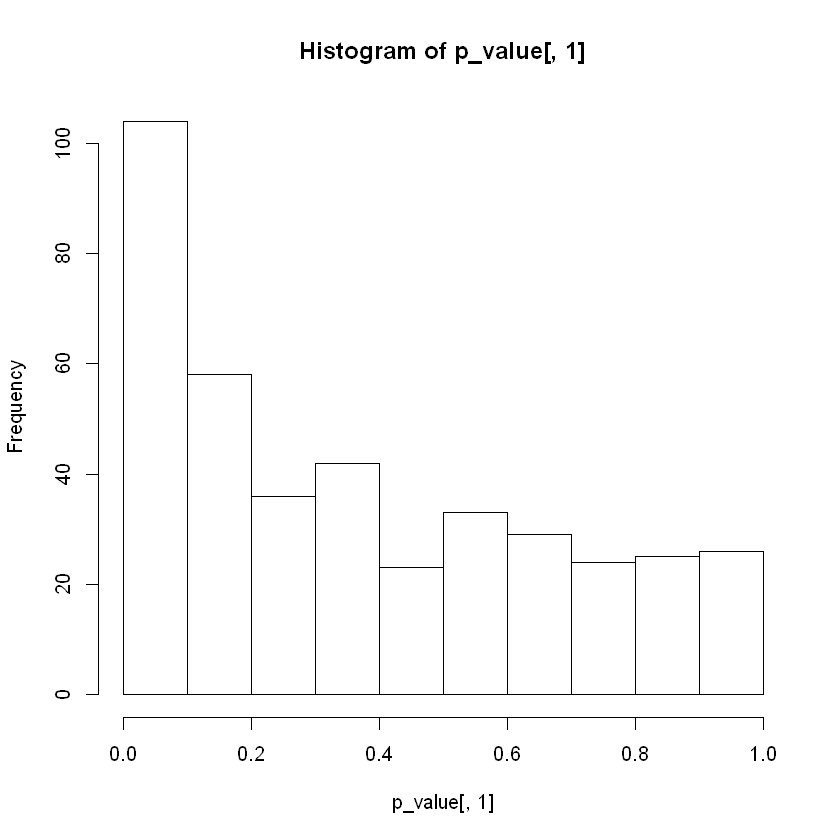

In [109]:
p_value=ret_list$pvalues
mu_t=ret_list$mu_t
P_t=ret_list$P_t
hist(p_value[,1])

In [120]:
#plot(P_t[2,], P[2,])
#plot(mu_t, mu)
ret_list

$P_t
          [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
[1,] 0.3961677 0.3875392 0.3833355 0.3746930 0.4002745 0.4049017 0.3708122
[2,] 0.3103591 0.3142214 0.3419240 0.3487103 0.3150616 0.2983283 0.3651284
[3,] 0.2934732 0.2982394 0.2747405 0.2765967 0.2846639 0.2967701 0.2640594
          [,8]      [,9]     [,10]     [,11]     [,12]     [,13]     [,14]
[1,] 0.3949245 0.3946765 0.3762687 0.4379681 0.3928911 0.3761388 0.4218854
[2,] 0.3129961 0.3267196 0.3498267 0.2786764 0.3275139 0.3372906 0.2742570
[3,] 0.2920794 0.2786039 0.2739046 0.2833555 0.2795950 0.2865706 0.3038576
         [,15]     [,16]     [,17]     [,18]     [,19]     [,20]     [,21]
[1,] 0.4132157 0.3991703 0.3980384 0.3611442 0.3810618 0.4251958 0.3868836
[2,] 0.2875551 0.2887938 0.3051209 0.3912577 0.3201319 0.2932258 0.3295856
[3,] 0.2992292 0.3120359 0.2968408 0.2475981 0.2988064 0.2815785 0.2835308
         [,22]     [,23]     [,24]     [,25]     [,26]     [,27]     [,28]
[1,] 0.3670646 0.3902969 0.3800806 0.3840656 0.3915145 0.4018023 0.3773982
[2,] 0.3517127 0.3264418 0.3576226 0.3161909 0.3391123 0.3050108 0.3559148
[3,] 0.2812227 0.2832613 0.2622967 0.2997435 0.2693731 0.2931869 0.2666870
         [,29]     [,30]     [,31]     [,32]     [,33]     [,34]     [,35]
[1,] 0.3893835 0.4207665 0.3687936 0.3839244 0.4012465 0.3744519 0.3715912
[2,] 0.3090541 0.3110382 0.3554621 0.3605639 0.3202942 0.3569035 0.3188542
[3,] 0.3015623 0.2681953 0.2757443 0.2555117 0.2784593 0.2686446 0.3095546
         [,36]     [,37]     [,38]     [,39]     [,40]     [,41]     [,42]
[1,] 0.3904818 0.3996895 0.4105501 0.3861092 0.3520413 0.3463444 0.4067236
[2,] 0.3229666 0.3055958 0.3263178 0.3552459 0.3873251 0.3830466 0.2988544
[3,] 0.2865516 0.2947148 0.2631322 0.2586450 0.2606336 0.2706090 0.2944220
         [,43]     [,44]     [,45]     [,46]     [,47]     [,48]     [,49]
[1,] 0.3621931 0.3674671 0.3608784 0.4110493 0.3780498 0.3562976 0.3797369
[2,] 0.3945049 0.3273173 0.3848119 0.3124495 0.3540332 0.3666184 0.3340324
[3,] 0.2433020 0.3052156 0.2543096 0.2765013 0.2679171 0.2770840 0.2862307
         [,50]     [,51]     [,52]     [,53]     [,54]     [,55]     [,56]
[1,] 0.3975443 0.3785895 0.3776188 0.3892468 0.3836331 0.3826338 0.3870065
[2,] 0.2704844 0.3243641 0.3564003 0.3345488 0.3505467 0.3253831 0.3405219
[3,] 0.3319712 0.2970464 0.2659808 0.2762044 0.2658202 0.2919831 0.2724716
         [,57]     [,58]     [,59]     [,60]     [,61]     [,62]     [,63]
[1,] 0.3678431 0.3709577 0.3595614 0.4033776 0.3922117 0.4069721 0.3865243
[2,] 0.3559713 0.3557400 0.3527330 0.3377378 0.3090367 0.3219706 0.3502490
[3,] 0.2761856 0.2733023 0.2877056 0.2588846 0.2987516 0.2710573 0.2632267
         [,64]     [,65]     [,66]     [,67]     [,68]     [,69]     [,70]
[1,] 0.3579073 0.3476408 0.3752619 0.3790619 0.4048983 0.3634219 0.3503672
[2,] 0.3582305 0.3792205 0.3452544 0.3298826 0.2941069 0.3659916 0.3909677
[3,] 0.2838622 0.2731386 0.2794837 0.2910555 0.3009948 0.2705865 0.2586650
         [,71]     [,72]     [,73]     [,74]     [,75]     [,76]     [,77]
[1,] 0.3766368 0.3734633 0.3546153 0.3855400 0.3798673 0.3950242 0.3798242
[2,] 0.3559685 0.3486945 0.3436693 0.3029854 0.2890901 0.3402485 0.3750909
[3,] 0.2673947 0.2778421 0.3017154 0.3114746 0.3310426 0.2647272 0.2450849
         [,78]     [,79]     [,80]     [,81]     [,82]     [,83]     [,84]
[1,] 0.3848409 0.4155029 0.3920295 0.4056417 0.4005085 0.3588643 0.3763867
[2,] 0.3171627 0.2709220 0.3507057 0.3224002 0.3302306 0.3833995 0.3495505
[3,] 0.2979964 0.3135750 0.2572648 0.2719581 0.2692609 0.2577362 0.2740628
         [,85]     [,86]     [,87]     [,88]     [,89]     [,90]
[1,] 0.4170493 0.4014855 0.3990198 0.4185402 0.3991738 0.3917884
[2,] 0.2982301 0.3121114 0.3160151 0.3190858 0.2968082 0.3330713
[3,] 0.2847206 0.2864032 0.2849651 0.2623740 0.3040180 0.2751403

$mu_t
            [,1]      [,2]      [,3]
  [1,] 0.1060957 0.3373587 0.2917848
  [2,] 0.3208035 0.2636130 0.4058022
  [3,] 0.2881558 

In [105]:
n=90
m=400
K=3
q=2




In [111]:
rDirichlet <- function(alpha_vec) {
        num <- length(alpha_vec)
        temp <- rgamma(num, shape = alpha_vec, rate = 1)
        return(temp/sum(temp))
    }
    #methyl matrix(2000(m),180(n))
    #哈哈哈这个学过了
    #这个函数的作用应该是估计p和u，u作为EM的初始值？
    CorDescent <- function(MethMatr, num_celltype, tol = 0.01, 
        showIter = FALSE) {
        err0 <- 0
        err1 <- 1000
        m <- nrow(MethMatr)
        n <- ncol(MethMatr)
        K <- num_celltype
        if (m < n) {
            stop("The CpgG site number must be larger than the sample number!")
        }
        P_matr_t <- vapply(seq_len(n), function(i) {
            rDirichlet(rep(2, K))#(k)
        }, FUN.VALUE = rep(-1, K))
        #P_matr_t(K,n),我猜是随机初始化,这个矩阵是要估计的composition
        while (abs(err1 - err0) >= tol) {
            err0 <- err1
            Dmat <- 2 * P_matr_t %*% t(P_matr_t)#(3,3)
            Amat <- cbind(diag(rep(1, K)), diag(rep(-1, K)))#(3,6)
            bvec <- c(rep(0, K), rep(-1, K))#(1,6)
            U_matr_t <- t(vapply(seq_len(m), function(j) {
                dvec <- 2 * P_matr_t %*% as.numeric(MethMatr[j, 
                  ])#column(3),每个元素对应估计的composition导致的该种细胞的总methylation值(对每一个点位估计)
                solu <- solve.QP(Dmat, dvec, Amat, bvec)
                solu$solution
            }, FUN.VALUE = rep(-1, K)))
            ###  U(2000,3), solu(3),这里的限制条件是solution的每个值大于等于0小于等于1，
            ###  求解的是min b*P_matr*t(P_matr)*t(b)-2*t(dev)*b,这里的每一个解b都对应一个site的三种细胞的不知道是啥(我猜是composition)
            ###猜测U估计的是每个点位三种细胞类型的methyl值
            Dmat <- 2 * t(U_matr_t) %*% U_matr_t#(3,3)
            Amat <- cbind(matrix(1, K, K), diag(rep(1, K)))
            bvec <- c(rep(1, K), rep(0, K))
            P_matr_t <- vapply(seq_len(n), function(i) {
                dvec <- 2 * t(U_matr_t) %*% as.numeric(MethMatr[, 
                  i])#column(3),每个type对应估计的composition导致的该种细胞的总methylation值(对每一个细胞估计)
                solu <- solve.QP(Dmat, dvec, Amat, bvec, meq = K)
                solu$solution
            }, FUN.VALUE = rep(-1, K))
            ### 这里的条件是x+y+z>=1,x,y,z>=0，解(3,180)对应
            
            
            
            err1 <- sum((MethMatr - U_matr_t %*% P_matr_t)^2)
            if (showIter == TRUE) {
                message("  ", err1, "\n")
            }
        }
        return(list(U = U_matr_t, P = P_matr_t))
    }

In [112]:
   Initialize <- function(Ometh, num_celltype) {
        K <- num_celltype
        sdrow <- apply(Ometh, 1, sd)#对Ometh(2000,180)每一行求sd，每一行对应一个site
        ind <- order(sdrow, decreasing = TRUE)#排个序
        m <- nrow(Ometh)
        if (m <= 1000) {
            num_cpg_for_init <- m
        }
        else {
            num_cpg_for_init <- max(3 * ncol(Ometh), floor(m/10))#floor盲猜取整，限制m的值，目的不明(应该是方便计算，因为后面只用到了p的估计，p的估计维度不受m的影响)
            if (num_cpg_for_init > m) {
                num_cpg_for_init <- m
            }
        }
        Ometh_part <- Ometh[ind[seq_len(num_cpg_for_init)], ]#取前多少个。。目的不明
        result <- CorDescent(Ometh_part, num_celltype = K, tol = 0.1, 
            showIter = FALSE)
        P_initial <- result$P
        mu_initial <- vapply(seq_len(m), function(j) {
            if (K > 2) {
                fit <- lm(Ometh[j, ] ~ as.matrix(t(P_initial[-1, 
                  ])))#as.,atrix作为(2,180)矩阵返回,n加t之后是(180,2)
            }
            ##P[-1,]意思是舍掉第一行，结果为(2,180)，(为啥舍掉一行也没搞明白)
            else {
                fit <- lm(Ometh[j, ] ~ as.numeric(P_initial[-1, 
                  ]))#as.numeric作为向量返回
            }
            tmp <- as.numeric(summary(fit)$coeff[, 1])##coeff的具体信息打在下面了
            tmp[-1] <- tmp[1] + tmp[-1]#[-1]是不带截距，+[1]是补正截距，目的未知
            tmp#这个tmp估计的应该是mu_k(每个cell type的baseline)之类的值，但是上面的算法还没看懂
        }, FUN.VALUE = rep(-1, K))
        ##噫，我看懂了，输出的mu(mu1,mu2,mu3)是对每种type mu的估计，别问为什么
        
        return(list(P_initial, mu_initial))#mu(3,2000)
    }
ret[[1]]-P

-0.15565384,-0.2156531,0.1339287,0.2639057,-0.1878877,-0.3528714719,0.32652274,-0.1942331,-0.17437142,0.03238506,...,0.32199355,0.24540309,0.85701246,0.27341287,-0.05624232,0.16429134,0.14258308,-0.06801434,-0.009217088,0.22474406
0.21074475,0.3403129,0.2276298,0.2938685,0.3482052,0.3523127969,0.07211447,0.3761400,0.25763289,-0.12569965,...,-0.22303336,-0.17170287,-0.06762647,-0.00765759,0.08421437,0.02776001,0.06365763,-0.36426889,0.343897553,-0.16958830
-0.05509091,-0.1246598,-0.3615585,-0.5577742,-0.1603175,0.0005586751,-0.39863721,-0.1819069,-0.08326147,0.09331459,...,-0.09896019,-0.07370022,-0.78938599,-0.26575528,-0.02797205,-0.19205135,-0.20624071,0.43228323,-0.334680465,-0.05515576


In [170]:
 my_EM=function(Ometh, X, P_t, mu_t, beta_t, sigma1, sigma2, tol, num_iter){
        error0=0
        error1=1000
        n=ncol(Ometh)
        m=nrow(Ometh)
        K=nrow(P_t)
        q=nrow(X)#phenotype
        #t表示循环子
        #我们规定每次更新不保留前值
        #Ometh (m,n), X (q,n), P_t (K,n), mu_t (m,K), beta_t (m,K,q), sigma1,sigma2 scalar
        #sigma_ijt (n,K,K)-(i,...) 本来应该是 (n,m K,K), 但我发现share variance的情况好像与j无关
        #算了我还是把j加上吧。。要不不好写 sigma_ijt (n,m,K,K)-(i,j,...)
        #mu_ijt (n,m,K) -(i,j,...)  column
        sigma_ijt=array(rep(0,n*m*K*K),dim=c(n,m,K,K))
        mu_ijt=array(rep(0,n*m*K),dim=c(n,m,K))
        
        for(t in 1:num_iter){
            
            for(i in 1:n){
                sum_pit_sq=sum(P_t[,i]*P_t[,i])
                for(j in 1:m){
                    #首先要算sigma_ij^t和 mu_ij^t
                    sigma_ijt[i, j, , ]=diag(sigma1**2, K, K)-(sigma1**4)*(P_t[, i]%*%t(P_t[, i])/((sigma2**2)+sum_pit_sq*sigma1**2))
                    mu_ijt[i, j, ]=t((Ometh[j,i]*t(P_t[,i])/(sigma2**2)+t(mu_t[j,]+beta_t[j,,]%*%X[,i])/sigma1**2)%*%sigma_ijt[i, j, , ])    
                }
                j=1
            }#upto here we have calculated all mu_ijt and sigma_ijt for this iteration
            #update mu_t[j, ] its really slow...
            i=1
            for(j_mu in 1:m){
                sum_respect_to_n=colSums(mu_ijt[, j_mu, ])
                numerator_mu=sum_respect_to_n-rowSums(beta_t[j_mu, , ]%*%X)
                mu_t[j_mu, ]=numerator_mu/n
            }
            j_mu=1
            #update beta..., 对j&l循环
            for(j_beta in 1:m){
                for(l_beta in 1:q){
                    y_jl=vapply(seq_len(n), function(i_beta){
                        mu_ijt[i_beta, j_beta, ]-mu_t[j_beta, ]-beta_t[j_beta, , ]%*%X[, i_beta]+beta_t[j_beta, ,l_beta]*X[l_beta,i_beta]
                    }, FUN.VALUE=rep(0,K))
                    numerator_beta=y_jl%*%(X[l_beta, ])
                    beta_t[j_beta, ,l_beta]=numerator_beta/(sum(X[l_beta, ]*X[l_beta, ]))
                }
                l_beta=1
            }
            j_beta=1
            #update p这个先等等。。
            #update sigma1
            numerator_sigma1=0
            for(i_sigma1 in 1:n){
                B_i=vapply(seq_len(m), function(j_sigma1){
                    mu_ijt[i_sigma1, j_sigma1, ]-mu_t[j_sigma1, ]-beta_t[j_sigma1, , ]%*%X[,i_sigma1]
                }, FUN.VALUE=rep(0,K))
                numerator_sigma1=numerator_sigma1+sum(diag(t(B_i)%*%B_i))+m*sum(diag(sigma_ijt[i_sigma1, 1, , ]))
            }
            i_sigma1=1
            sigma1_square=numerator_sigma1/(m*n*K)
            sigma1=sqrt(sigma1_square)
            #update sigma2
            temp=(1/n)*sum(vapply(seq_len(n), function(i_sigma2){t(P_t[, i_sigma2])%*%sigma_ijt[i_sigma2, 1, , ]%*%P_t[, i_sigma2]}, FUN.VALUE=rep(1,1)))#sigma_ijt j取1即可
            #还要一个对i循环
            for(i_sigma2_1 in 1:n){
                temp=temp+(1/(m*n))*sum(vapply(seq_len(m), function(j){(Ometh[j, i_sigma2_1]-t(mu_ijt[i_sigma2_1, j, ])%*%P_t[, i_sigma2_1])**2}, FUN.VALUE=rep(1,1)))
            }
            i_sigma2_1=1
            sigma2=sqrt(temp)
            #update P_t
            Amat=cbind(matrix(1, K, K), diag(rep(1, K)))
            bvec=c(rep(1, K), rep(0, K))
            P_t=vapply(seq_len(n), function(i){
                Dmat=2*(m*sigma_ijt[i, 1, , ]+t(mu_ijt[i, , ])%*%mu_ijt[i, , ])
                dvec=2*t(colSums(Ometh[ , i]*mu_ijt[i, , ]))
                solu=solve.QP(Dmat, dvec, Amat, bvec, meq = K)
                return(solu$solution)
            }, FUN.VALUE=rep(1, K))
            
            
        }
        ret_list=list("P_t"=P_t, "mu_t"=mu_t, "beta_t"=beta_t, "sigma1"=sigma1, "sigma2"=sigma2)
        return(ret_list)
    }

In [203]:
ret=Initialize(Ometh, K)
beta_t <- beta
sigma1=0.1
sigma2=0.1
init <- Initialize(Ometh, K)
P_t <- init[[1]]
mu_t <- mu
num_iter=50

In [204]:

ret_1=my_EM(Ometh, X, P_t, mu_t, beta_t, sigma1, sigma2, tol, num_iter)

ERROR: Error in mu_ijt[, ]: 量度数目不对


In [197]:
for(j in 1:m){
    

tmp1=matrix(0,q,q)
tmp2=matrix(0,K,q)
for(i in 1:n){
    tmp1=tmp1+X[, i]%*%t(X[,i])
    tmp2=tmp2+(mu_ijt[i, j, ]-mu_t[j, ])%*%t(X[,i])
}
i=1
beta_t[j , ]=tmp2%*%solve(tmp1)
    }
j=1

ERROR: Error in beta_t[j, ] <- tmp2 %*% solve(tmp1): 矩阵里的下标数目不对


In [198]:
ret_list=ret_1
alpha=0.05
tmp <- NULL
    for (ell in seq_len(p)) {
        tmp <- cbind(tmp, X[ell, ] * t(ret_list$P_t))#注意不是矩阵乘法
    }#(180,6)不知道具体是啥。。。每种细胞对表现型的贡献。。？
    x_matr <- cbind(tmp, t(ret_list$P_t)[, seq(2, K)])#(180,8)
    x_matr <- as.matrix(x_matr)
    pvalues <- t(vapply(seq_len(m), function(j) {
        y_vec <- Ometh[j, ]
        fit <- lm(y_vec ~ x_matr)
        summary(fit)$coef[seq(2, (1 + p * K)), 4]#第四列是p，第一行是截距，后六行对应斜率，大概吧
    }, FUN.VALUE = rep(-1, p * K)))#p(2000,6)判断的是每种cell type在每个点位受不受表现型影响
    message("  Done!\n")
    ret_list[[7]] <- pvalues
    names(ret_list)[7] <- "pvalues"
    names(ret_list)[6] <- "pBIC"
    d <- (K - 1) * n + m * (1 + 2 * K + p * K)
    d0 <- sum(ret_list$pvalues > alpha/(p * m * K))
    ret_list[[6]] <- ret_list[[6]] - log(n) * d + log(n) * (d - 
        d0)#这个BIC是啥


  Done!



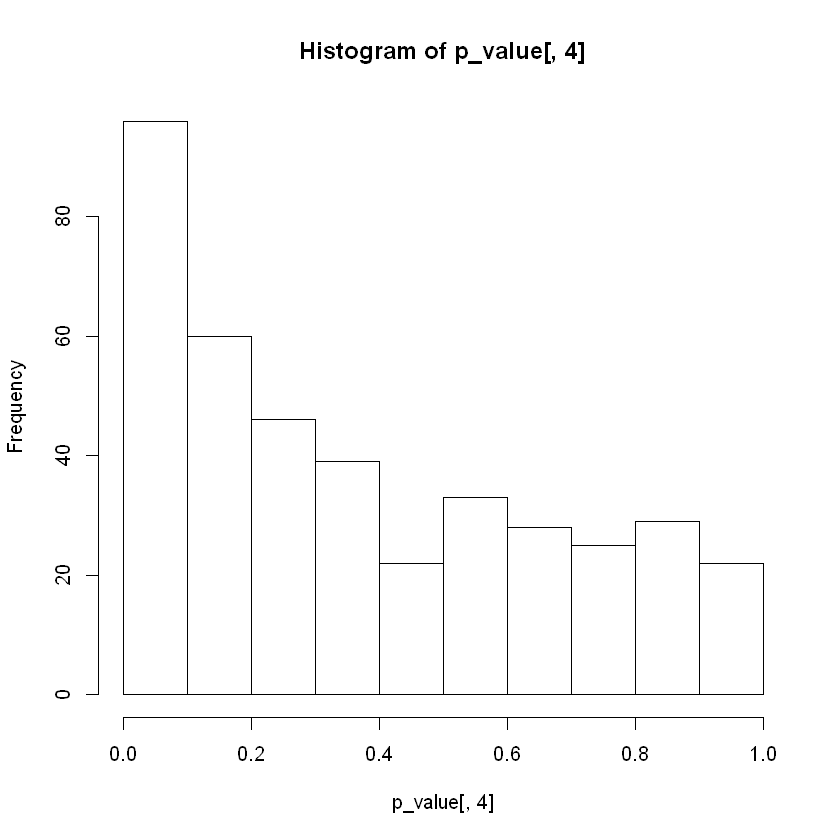

In [199]:
p_value=ret_list$pvalues
mu_t=ret_list$mu_t
P_t=ret_list$P_t
hist(p_value[, 4])


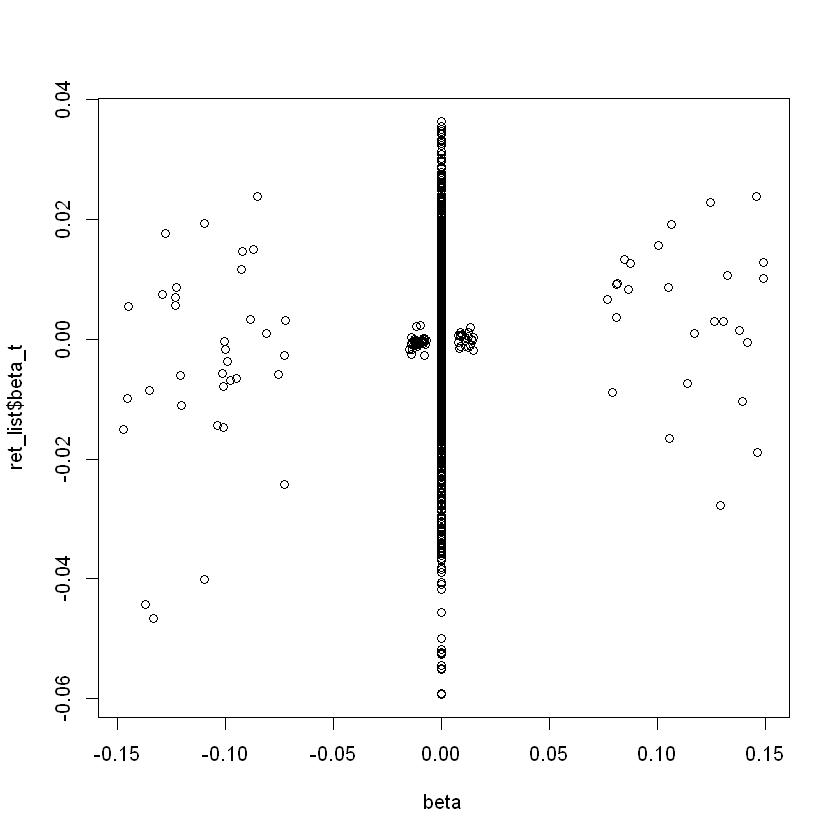

In [226]:
plot(beta, ret_list$beta_t)

png 
  2

png 
  2

png 
  2

[1] 0.05963943

[1] 0.1219551

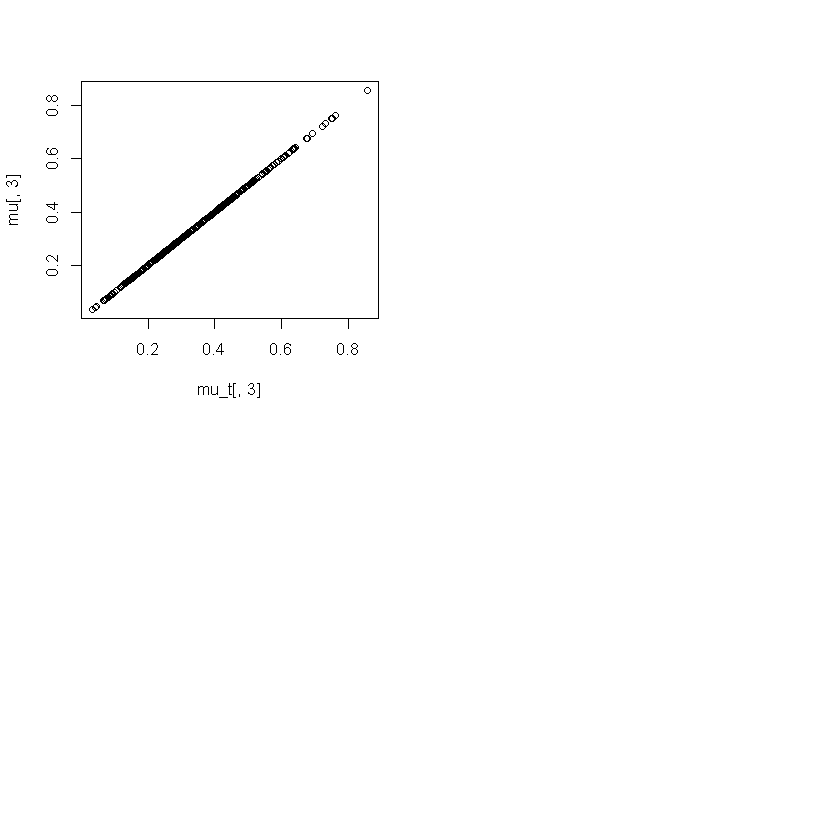

In [225]:
par(mfrow = c(2,2))
png("P1.png")
plot(P_t[2,], P[1,])
dev.off()
png("P2.png")
plot(P_t[1,], P[2,])
dev.off()

png("P3.png")
plot(P_t[3,], P[3,])
dev.off()
plot(mu_t[,3], mu[,3])
ret_list$sigma1
ret_list$sigma2

In [222]:
library(HIREewas)
png(filename = "test.png")
riskCpGpattern(ret_list$pvalues[1:100, c(1,2,3)],
main_title="Detected association pattern\n with age", hc_row_ind = FALSE)
dev.off()

png 
  2

In [181]:
getwd()

[1] "C:/Users/Misika Mei/Desktop/ACADEMICS/2019 FALL/Research"